<h1> image feature extraction </h1>

In [1]:
# make imports

import os
import sys
import PIL
import numpy as np
from numpy import asarray
import pickle
from PIL import Image, ImageEnhance
from matplotlib import image,pyplot

In [2]:
# load all images and apply the preprocessing steps to them

def preprocess_images(dir):

    # make a list of tuples to store image data along with image name
    ok_images = []

    i = 0

    for file in os.listdir(dir):
        
        #check if file is not a hidden file
        if (file[0] == '.'):
            continue

        # iterating through all product ids in the images folder
        curr_dir = os.path.join(dir, file)

        # iterating through all images corresponding to a product id
        for iter_image in os.listdir(curr_dir):

            i += 1

            # find image path
            image_path = os.path.join(curr_dir, iter_image)

            # read the image and drop corrupted images
            try:
                curr_image = Image.open(image_path)
                curr_image_data = asarray(curr_image) #convert image to numpy array
                ok_images.append((curr_image_data, iter_image))

            except PIL.UnidentifiedImageError:
                print(f"{iter_image} is corrupted, it shall be dropped!")

    # creating preprocessed images list (store 2 tuples of image data and label)
    preprocessed_images = []

    # preprocess the images and store them in the preprocessed_images list
    for image_data, image_name in ok_images:

        curr_image = Image.fromarray(image_data)

        # resize the image
        curr_image = curr_image.resize((64,64))

        # append resized image
        preprocessed_images.append(((asarray(curr_image)), image_name))

        # scaling pixel values to produce contrast
        curr_image = Image.eval(curr_image, lambda x: x*1.5)

        # add current image to the list
        preprocessed_images.append(((asarray(curr_image)), image_name))

        # add geometrical orientations of the image to the list
        preprocessed_images.append(((asarray(curr_image.transpose(Image.FLIP_LEFT_RIGHT))), image_name))
        preprocessed_images.append(((asarray(curr_image.transpose(Image.FLIP_TOP_BOTTOM))), image_name))

        # add rotations of the image to the list
        preprocessed_images.append(((asarray(curr_image.rotate(90))), image_name))
        preprocessed_images.append(((asarray(curr_image.rotate(180))), image_name))
        preprocessed_images.append(((asarray(curr_image.rotate(270))), image_name))

        # ADD VARIATIONS OF BRIGHTNESS AND EXPOSURE TO THE LIST

        brightness_factor = 1.5  # >1 for brighter & <1 for darker

        exposure_factor = 1.5  # >1 for more exposure & <1 for less exposure
        
        enhancer_brightness = ImageEnhance.Brightness(curr_image)
        brightened_image = enhancer_brightness.enhance(brightness_factor)
        
        enhancer_exposure = ImageEnhance.Contrast(brightened_image)

        #add brightened image with more exposure
        exposed_image = enhancer_exposure.enhance(exposure_factor)
        preprocessed_images.append(((asarray(exposed_image)), image_name))

        #add brightened image with less exposure
        exposure_factor = 0.5
        exposed_image = enhancer_exposure.enhance(exposure_factor)
        preprocessed_images.append(((asarray(exposed_image)), image_name))

        #darken image
        brightness_factor = 0.5
        darkened_image = enhancer_brightness.enhance(brightness_factor)

        #add darkened image with more exposure
        exposure_factor = 1.5
        enhancer_exposure = ImageEnhance.Contrast(darkened_image)

        exposed_image = enhancer_exposure.enhance(exposure_factor)
        preprocessed_images.append(((asarray(exposed_image)), image_name))

        #add darkened image with less exposure
        exposure_factor = 0.5
        exposed_image = enhancer_exposure.enhance(exposure_factor)
        preprocessed_images.append(((asarray(exposed_image)), image_name))

    return preprocessed_images

preprocessed_images = preprocess_images("images")

2912_1.jpg is corrupted, it shall be dropped!
2235_1.jpg is corrupted, it shall be dropped!
2235_2.jpg is corrupted, it shall be dropped!
2088_1.jpg is corrupted, it shall be dropped!
3474_1.jpg is corrupted, it shall be dropped!
2265_1.jpg is corrupted, it shall be dropped!
3317_2.jpg is corrupted, it shall be dropped!
3317_1.jpg is corrupted, it shall be dropped!


Rescaling and adding contrast are pre-processing steps and the remaining steps are augmentation steps to extract better features from the images.

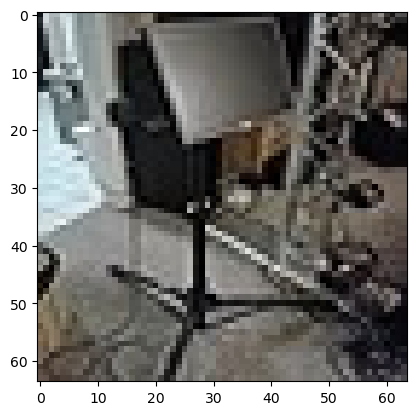

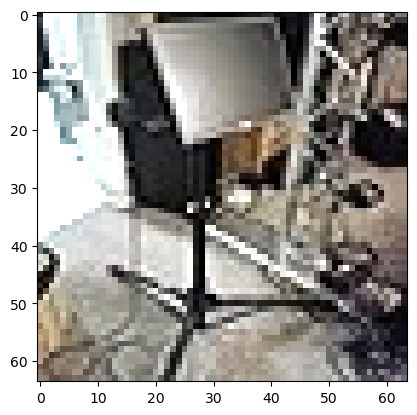

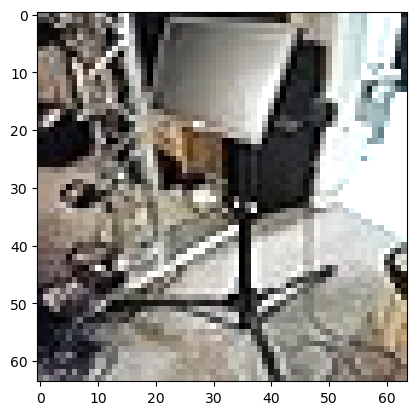

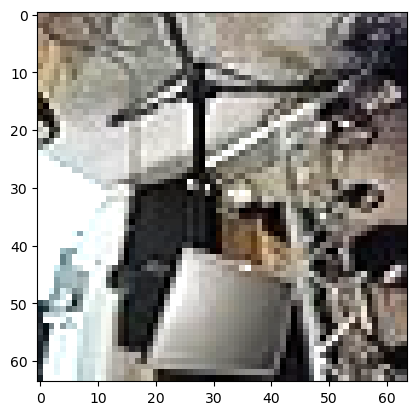

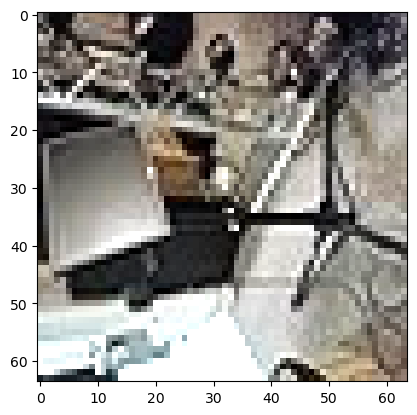

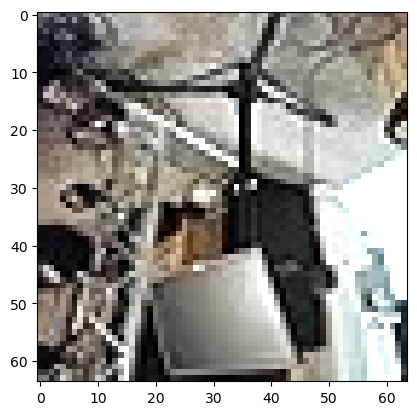

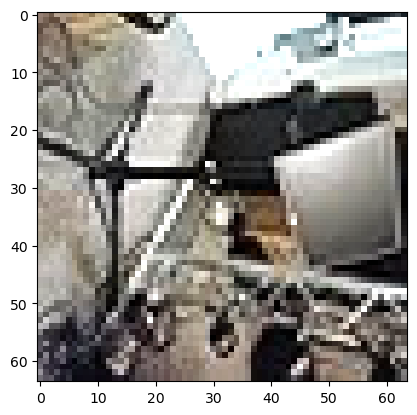

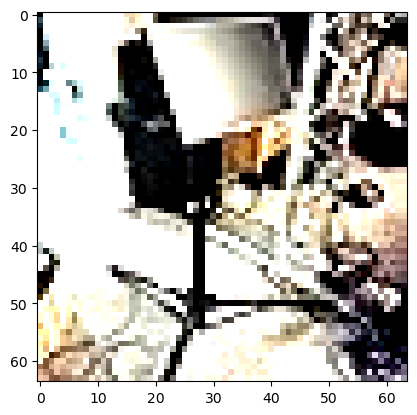

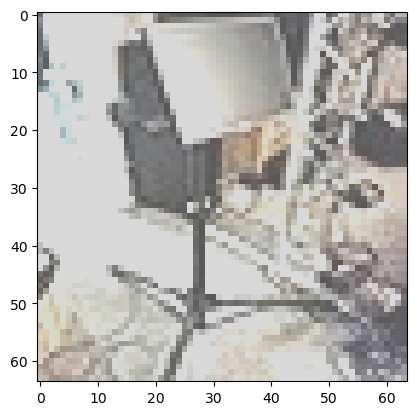

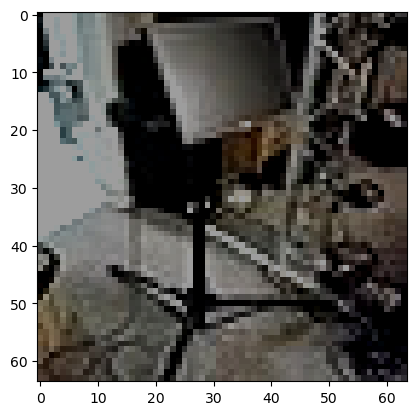

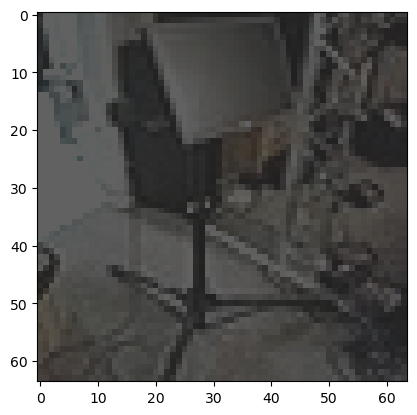

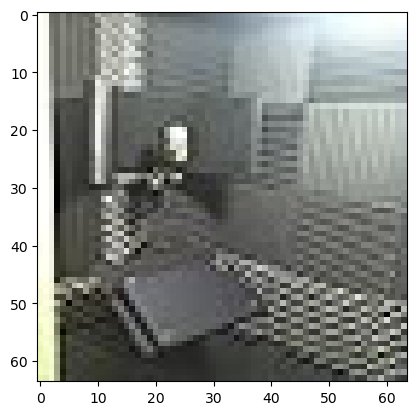

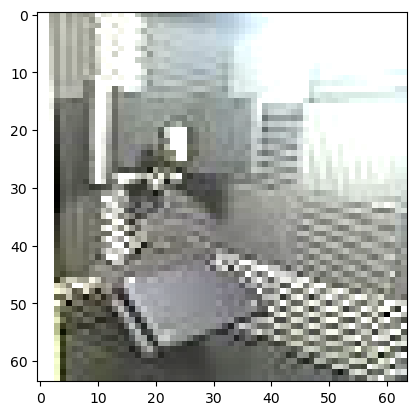

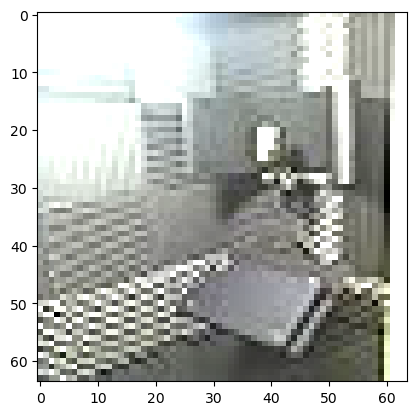

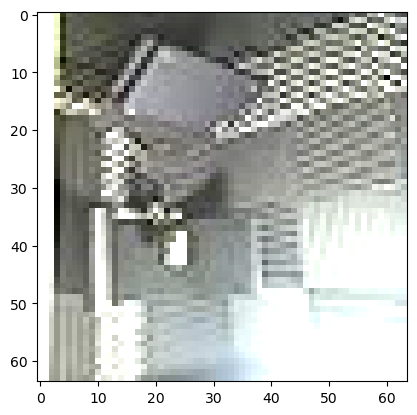

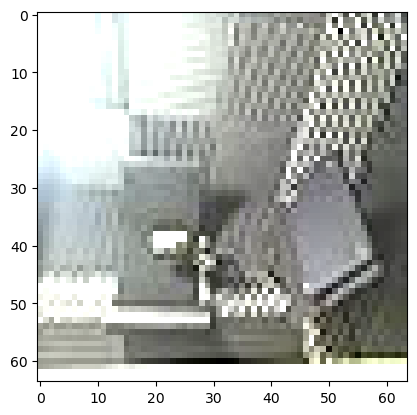

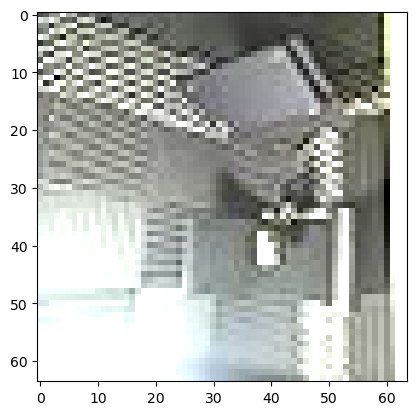

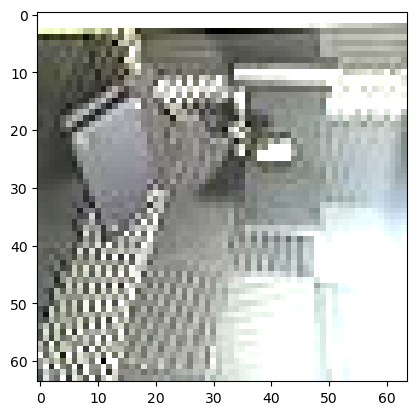

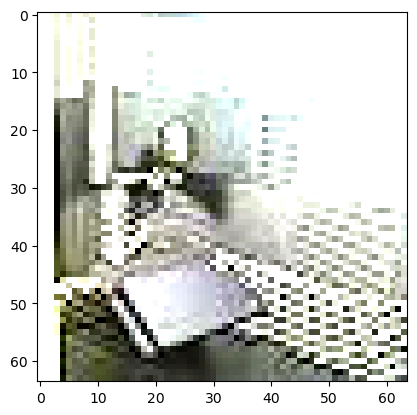

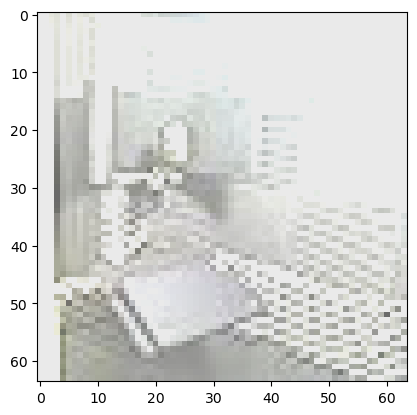

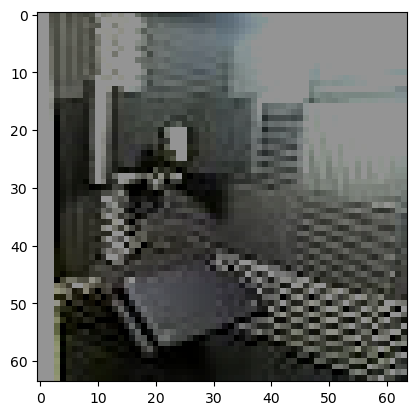

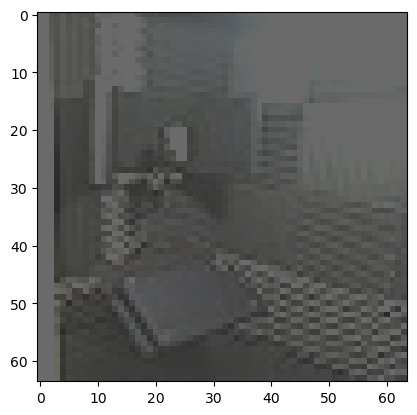

In [3]:
#printing sample images after preprocessing

for i in range(22):
    #print the image
    pyplot.imshow(preprocessed_images[i][0])
    pyplot.show()

In [4]:
# make imports to extract features

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision

In [5]:
# set device to mps as im using macOS

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("Using MPS")
    device = torch.device("mps")

Using MPS


In [6]:
# make CustomDataset class to load preprocessed_images for feature extraction

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# define transform
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert numpy array to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize if needed
])

# init lists to store images(as numpy arrays) and its corresponding label
image_features = []
image_labels = []

for img, img_label in preprocessed_images:
    image_features.append(img)
    new_label = (img_label.split('_'))[0]
    image_labels.append(new_label)

# build dataset to use with resnet
torch_dataset = CustomDataset(images=image_features, labels=image_labels, transform=transform)

# create dataloader
dataloader = DataLoader(torch_dataset, batch_size=32, shuffle=True)

In [7]:
# load pre-trained ResNet model
resnet = models.resnet18(pretrained=True).to(device)

# remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1]).to(device)

# set the model to evaluation mode
resnet.eval()

/Users/mo/Downloads/ENTER/envs/env_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mo/Downloads/ENTER/envs/env_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [8]:
# function to extract features
def extract_features(model, dataloader):
    features_list = []
    for batch_images, batch_labels in dataloader:
        batch_images = batch_images.to(device)
        with torch.no_grad():
            features = model(batch_images)
        features_list.append(features.squeeze())
    return torch.cat(features_list)

# Extract features
features = extract_features(resnet, dataloader)

# Normalize features
features_mean = torch.mean(features, dim=0).to(device)
features_std = torch.std(features, dim=0).to(device)
normalized_features = (features - features_mean) / features_std

# Convert normalized features to numpy array
normalized_features_np = normalized_features.cpu().numpy()

/Users/mo/Downloads/ENTER/envs/env_pytorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [9]:
print(normalized_features_np.shape)

(18040, 512)


In [10]:
# save the extracted features to a pickle file

with open('extracted_features.pkl', 'wb') as f:
    pickle.dump(normalized_features_np, f)